In [1]:
import torch
import torchvision
from tqdm import trange
import cv2
from torchvision import transforms
from torch.utils.data import random_split, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print(device)

c:\Users\Giacomo\miniconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossibile trovare la procedura specificata'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cpu


In [2]:
!rm best_model.pt

"rm" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(size=[224,224]),
    # transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(size=[224,224]),
    # transforms.Normalize(mean, std),
])

In [4]:
def open_image(path):
    return Image.open(path).convert('RGB')


In [22]:
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=open_image)

trainset_classes = trainset.classes.copy()

subset_size = int(0.15*len(trainset))

validset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=open_image)

indices = torch.randperm(len(trainset))

valid_indices = indices[:subset_size]
train_indices = indices[subset_size:]

trainset = Subset(trainset, train_indices)
validset = Subset(validset, valid_indices)

# Apply transformations only to the training set
trainset.dataset.transform = train_transform
# Apply transformations to the validation set
validset.dataset.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=test_transform, loader=open_image)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(trainset)},  splitted validset: {len(validset)}')

entire train folder: 1275, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in C:\Users\Giacomo/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Giacomo\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Giacomo\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=15, bias=True) #adapting to 15 classes

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[6].parameters():
    param.requires_grad = True

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
# The same plotting function from the previous lab
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [18]:
image = next(iter(trainloader))
image[0].min()

c:\Users\Giacomo\miniconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(-2.1179)

In [9]:
images, labels = next(iter(trainloader))

print(images[0])

# imshow(torchvision.utils.make_grid(images))

tensor([[[ 1.1321,  1.1174,  1.1434,  ...,  1.4043,  1.4068,  1.4191],
         [ 1.1292,  1.1302,  1.1461,  ...,  1.4098,  1.4110,  1.4177],
         [ 1.1281,  1.1426,  1.1453,  ...,  1.4030,  1.4098,  1.4098],
         ...,
         [-1.8547, -1.8663, -1.8372,  ..., -0.4205, -2.0395, -1.5304],
         [-1.8506, -1.8518, -1.8302,  ..., -0.8244, -1.9910, -1.5980],
         [-1.8584, -1.8486, -1.8345,  ..., -1.5529, -1.8848, -1.6792]],

        [[ 1.2868,  1.2718,  1.2984,  ...,  1.5651,  1.5677,  1.5803],
         [ 1.2838,  1.2849,  1.3012,  ...,  1.5707,  1.5719,  1.5788],
         [ 1.2828,  1.2976,  1.3003,  ...,  1.5638,  1.5707,  1.5707],
         ...,
         [-1.7666, -1.7785, -1.7487,  ..., -0.3004, -1.9555, -1.4351],
         [-1.7624, -1.7637, -1.7416,  ..., -0.7133, -1.9060, -1.5042],
         [-1.7704, -1.7604, -1.7460,  ..., -1.4581, -1.7974, -1.5872]],

        [[ 1.5033,  1.4884,  1.5148,  ...,  1.7804,  1.7829,  1.7954],
         [ 1.5004,  1.5014,  1.5176,  ...,  1

c:\Users\Giacomo\miniconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
# Checking initialization printing mean, std, max biases in the classifier fully connected layer

model.classifier[1].weight.mean(), model.classifier[1].weight.std(), model.classifier[1].bias.max()

(tensor(-0.0006), tensor(0.0093), tensor(0.0941))

In [11]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.float()
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [12]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [13]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0
    for x, y in iter(loader):
        x = x.float()
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return running_loss/len(loader.dataset)
    

In [14]:
def get_test_predictions(model, test_loader):
    pred_tensor = torch.empty(len(testset), dtype = torch.uint8)
    labels_tensor = torch.empty_like(pred_tensor)

    for i, data in enumerate(test_loader):
        x, y = data
        x = x.float()
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)

        prediction = torch.argmax(prediction, axis=1)
    
        pred_tensor[i*BATCH_SIZE: min((i+1)*BATCH_SIZE, i*BATCH_SIZE + y.size()[0])] = prediction # we have that strange equation because the dataset is not divisible by 32
        labels_tensor[i*BATCH_SIZE: min((i+1)*BATCH_SIZE, i*BATCH_SIZE + y.size()[0])] = y
    
    return (pred_tensor, labels_tensor)

In [15]:
epochs = 50
losses = []
accuracies = []
for epoch in trange(epochs, desc="Training: ", unit="epoch"):
    accuracy = get_accuracy(model, validloader)
    accuracies.append(accuracy)
    curr_loss = train_one_epoch(model, trainloader, optimizer)
    losses.append(curr_loss)
print(f"Final accuracy: {get_accuracy(model, validloader)}")

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]c:\Users\Giacomo\miniconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Training: 100%|██████████| 50/50 [13:13<00:00, 15.86s/epoch]


Final accuracy: 0.8355555534362793


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


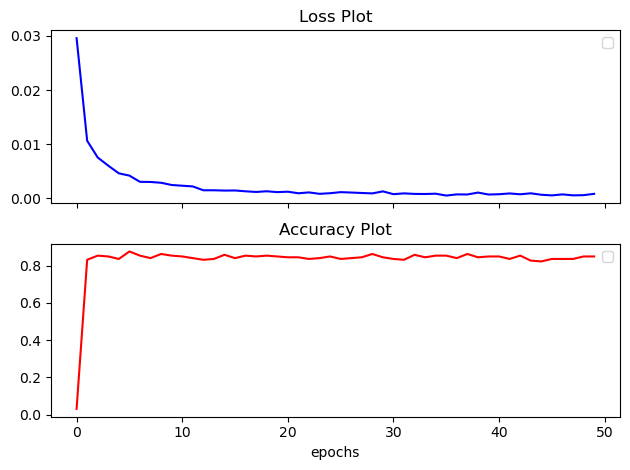

In [16]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

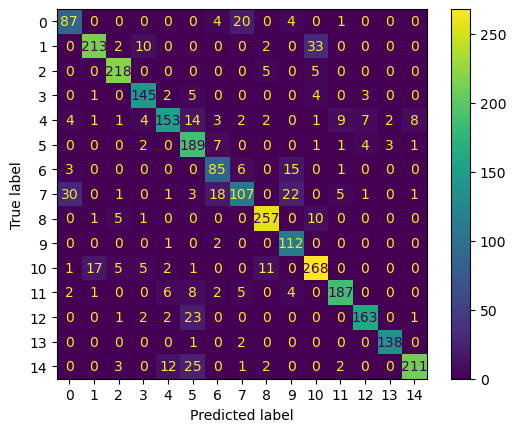

In [24]:
pred_tensor, labels_tensor = get_test_predictions(model, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

In [ ]:
es_model = CNN().to(device) # early stopping model
es_opt = torch.optim.SGD(es_model.parameters(), lr=0.001, momentum=0.9)

es_model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=15, bias=True)
  )
)

In [ ]:
GL = lambda val_err, opt_err: 100*((val_err/opt_err) - 1)

MAX_EPOCHS = 1000
epoch = 0

alpha = 100

accuracies = []
losses = []
valid_errors = []

SAVE_PATH = 'best_model.pt'

optimal_error = np.inf
validation_error = 0


while(GL(validation_error, optimal_error) < alpha and epoch < MAX_EPOCHS):
	alpha *= 0.98
	one_epoch_loss = train_one_epoch(es_model, trainloader, es_opt)
	epoch += 1
	validation_error = 1 - get_accuracy(es_model, validloader)
	print(f"Epoch: {epoch : 04d}, Test loss: {one_epoch_loss : .05f}, GL: {GL(validation_error, optimal_error): e}, error: {validation_error: e}", end="\r")

	losses.append(one_epoch_loss)
	accuracies.append(1 - validation_error)

	if validation_error < optimal_error:
		optimal_error = validation_error
		torch.save({
			"model_state_dict": es_model.state_dict(),
			"optimizer_state_dict": es_opt.state_dict()
		}, SAVE_PATH)
print('\r')
print(f'GL: {GL(validation_error, optimal_error)}')

Epoch:  015, Test loss:  0.02983, GL:  7.807018e+01, error:  9.022222e-01
GL: 78.07017517089844


In [ ]:
es_model = CNN().to(device)
checkpoint = torch.load(SAVE_PATH)
es_model.load_state_dict(checkpoint["model_state_dict"])

print(f"Final accuracy: {get_accuracy(es_model, validloader)}")

Final accuracy: 0.4933333396911621


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


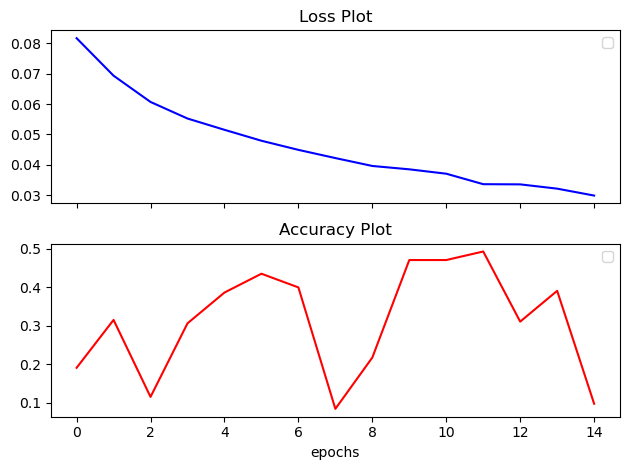

In [ ]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
ax1.plot(losses, color='blue')
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
ax2.plot(accuracies, color='red')
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

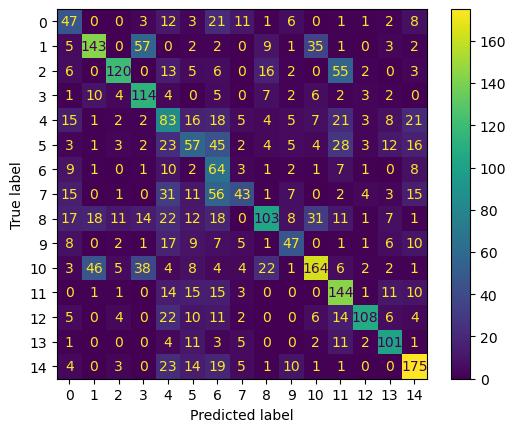

In [ ]:
pred_tensor, labels_tensor = get_test_predictions(es_model, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

## Ricorda di verificare perché la confusion matrix non è simmetrica anche se ad intuito dovrebbe

controllando il dataset vediamo che non bilanciato e quindi ci aspettiamo che la matrice non sia simmetrica e le classi che sono maggiormente presenti vegano classificate "più correttamente" di quelle meno presenti

In [ ]:
trainset_classes

['Bedroom',
 'Coast',
 'Forest',
 'Highway',
 'Industrial',
 'InsideCity',
 'Kitchen',
 'LivingRoom',
 'Mountain',
 'Office',
 'OpenCountry',
 'Store',
 'Street',
 'Suburb',
 'TallBuilding']

In [ ]:
## Stampa numero immagini per classe per vedere se dataset è bilanciato
np.sum(cm, axis=1)

array([116, 260, 228, 160, 211, 208, 110, 189, 274, 115, 310, 215, 192,
       141, 256], dtype=int64)

tensor([3.0000, 0.4000])